# Stable unCLIP Mix Visualizations

This notebook runs the Imagenette mixing experiment: we blend embeddings from two categories, reconstruct them with the MLP, and compare Stable unCLIP generations against the raw fragmented mixes.

# CLIP + Stable unCLIP Reconstruction Demo

This notebook mirrors the new CLIP-based restoration flow in `src/knn_restore.py`.
It loads Imagenette samples, trains the residual MLP to map corrupted CLIP image
embeddings back to the clean space, and decodes the reconstructions with
`sd2-community/stable-diffusion-2-1-unclip-small`. The last section visualizes
clean/corrupted/reconstructed triplets side by side.

In [1]:
from pathlib import Path
import sys

import torch
from torchvision import transforms
import matplotlib.pyplot as plt


def find_src_root():
    cwd = Path.cwd()
    candidates = [cwd, cwd / "RAE"]
    for parent in cwd.parents:
        candidates.extend([parent, parent / "RAE"])
    for base in candidates:
        src = base / "src"
        if src.exists():
            return base, src
    raise RuntimeError(
        "Could not locate 'src' directory. Run this notebook from the repo root or RAE/."
    )


repo_root, src_root = find_src_root()
if str(src_root) not in sys.path:
    sys.path.append(str(src_root))

from knn_restore import (
    EncoderConfigs,
    ReconstructConfigs,
    GlobalConfigs,
    load_encoder,
    extract_features,
    create_dataloaders,
    train,
    evaluate,
    seed_everything,
    set_up,
    apply_mix_embeddings,
)
from restore_methods import evaluate_reconstruction
import dataloader
from diffusers import StableUnCLIPImg2ImgPipeline

import random

/orcd/scratch/orcd/010/jianggy/micromamba/envs/rae/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/orcd/scratch/orcd/010/jianggy/micromamba/envs/rae/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assign

In [2]:
global_cfg, encoder_cfg, restore_cfg, unclip_cfg = set_up()
device = torch.device(global_cfg.device)
seed = global_cfg.seed
seed_everything(seed)

# Notebook-friendly overrides
batch_size = 32
num_workers = 4
corrupt_range = (0.50, 0.70)
max_train = None
max_val = None
num_visualize = 4

restore_cfg.hidden_dims = 1024
restore_cfg.epochs = 3

global_cfg.batch_size = batch_size
global_cfg.num_workers = num_workers
global_cfg.corrupt_range = corrupt_range
global_cfg.scheme = "mix"

generator = torch.Generator(device=device).manual_seed(seed)
global_cfg.generator = generator

torch.manual_seed(seed)

IMAGENET_MEAN = torch.tensor((0.485, 0.456, 0.406)).view(1, 3, 1, 1)
IMAGENET_STD = torch.tensor((0.229, 0.224, 0.225)).view(1, 3, 1, 1)


global_cfg.mix_alpha = 0.5

Building Encoder configs...


In [3]:

clean_train_loader, clean_val_loader = dataloader.get_imagenette_loaders(
    scheme="baseline",
    corrupt_range=None,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
)
corrupt_train_loader, corrupt_val_loader = dataloader.get_imagenette_loaders(
    scheme=global_cfg.scheme,
    corrupt_range=global_cfg.corrupt_range,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
)

class_names = list(clean_train_loader.dataset.classes)
print("Imagenette classes:", class_names)

def denormalize(batch: torch.Tensor) -> torch.Tensor:
    return (batch * IMAGENET_STD.to(batch) + IMAGENET_MEAN.to(batch)).clamp(0, 1)


Imagenette classes: ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']


In [4]:

encoder_bundle = load_encoder(encoder_cfg, device)

clean_train_embeddings, train_labels = extract_features(
    encoder_bundle,
    clean_train_loader,
    scheme="baseline",
    device=device,
    generator=torch.Generator(device=device).manual_seed(seed),
    noise_std=None,
    max_items=max_train,
)
corrupt_train_embeddings, _ = extract_features(
    encoder_bundle,
    corrupt_train_loader,
    scheme=global_cfg.scheme,
    device=device,
    generator=torch.Generator(device=device).manual_seed(seed + 1),
    noise_std=None,
    max_items=max_train,
)
clean_valid_embeddings, valid_labels = extract_features(
    encoder_bundle,
    clean_val_loader,
    scheme="baseline",
    device=device,
    generator=torch.Generator(device=device).manual_seed(seed + 2),
    noise_std=None,
    max_items=max_val,
)
corrupt_valid_embeddings, _ = extract_features(
    encoder_bundle,
    corrupt_val_loader,
    scheme=global_cfg.scheme,
    device=device,
    generator=torch.Generator(device=device).manual_seed(seed + 3),
    noise_std=None,
    max_items=max_val,
)

if global_cfg.scheme == "mix":
    mix_alpha = global_cfg.mix_alpha if global_cfg.mix_alpha is not None else 0.5
    gen_train = torch.Generator().manual_seed(seed)
    corrupt_train_embeddings, mix_pairs_train, mix_perm_train = apply_mix_embeddings(
        corrupt_train_embeddings, train_labels, mix_alpha, gen_train
    )
    gen_val = torch.Generator().manual_seed(seed + 1)
    corrupt_valid_embeddings, mix_pairs_valid, mix_perm_valid = apply_mix_embeddings(
        corrupt_valid_embeddings, valid_labels, mix_alpha, gen_val
    )
else:
    mix_pairs_valid = None
    mix_perm_valid = None

train_loader, train_eval_loader, val_loader = create_dataloaders(
    global_cfg,
    restore_cfg,
    clean_train_embeddings,
    corrupt_train_embeddings,
    clean_valid_embeddings,
    corrupt_valid_embeddings,
)

model, losses = train(
    restore_cfg,
    train_loader,
    val_loader,
    device=device,
    feature_dim=encoder_bundle["feature_dim"],
    normalize_outputs=encoder_bundle.get("normalize", True),
)
train_pred, valid_pred = evaluate(
    model,
    train_eval_loader,
    val_loader,
    device,
    encoder_bundle.get("normalize", True),
)
print("Train metrics:", evaluate_reconstruction(train_pred, clean_train_embeddings))
print("Valid metrics:", evaluate_reconstruction(valid_pred, clean_valid_embeddings))


Training epochs:  33%|███▎      | 1/3 [00:00<00:00,  2.16it/s]

Epoch 1/3 - train_loss: 0.091151 - val_loss: 0.065090


Training epochs:  67%|██████▋   | 2/3 [00:00<00:00,  2.45it/s]

Epoch 2/3 - train_loss: 0.062896 - val_loss: 0.058394


Training epochs: 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

Epoch 3/3 - train_loss: 0.057070 - val_loss: 0.054234
Train metrics: {'mse': 0.05193270742893219, 'mean_l2': 6.250114440917969, 'mean_cos': 0.9402088522911072}
Valid metrics: {'mse': 0.05423423647880554, 'mean_l2': 6.383906841278076, 'mean_cos': 0.9373859763145447}


In [5]:

if global_cfg.scheme == "mix":
    num_recon = min(num_visualize, valid_pred.size(0))
    primary_indices = list(range(num_recon))
    partner_indices = [int(x) for x in mix_perm_valid[:num_recon].tolist()]
    needed_indices = set(primary_indices + partner_indices)

    source_cache = {}
    current_idx = 0
    for batch, _ in corrupt_val_loader:
        batch_denorm = denormalize(batch)
        for b in range(batch.size(0)):
            if current_idx in needed_indices and current_idx not in source_cache:
                source_cache[current_idx] = batch_denorm[b].cpu()
                if len(source_cache) == len(needed_indices):
                    break
            current_idx += 1
        if len(source_cache) == len(needed_indices):
            break

    source_pairs = [
        (source_cache[idx0], source_cache[idx1])
        for idx0, idx1 in zip(primary_indices, partner_indices)
    ]
    mixed_inputs = [
        (mix_alpha * pair[0] + (1 - mix_alpha) * pair[1]).clamp(0, 1)
        for pair in source_pairs
    ]
else:
    num_recon = min(num_visualize, valid_pred.size(0))
    source_pairs = []
    mixed_inputs = []
    current_idx = 0
    for batch, _ in corrupt_val_loader:
        batch_denorm = denormalize(batch)
        for b in range(batch.size(0)):
            tensor = batch_denorm[b].cpu()
            source_pairs.append((tensor, tensor))
            mixed_inputs.append(tensor)
            current_idx += 1
            if len(source_pairs) >= num_recon:
                break
        if len(source_pairs) >= num_recon:
            break


In [6]:

pipe_dtype = torch.float16 if device.type == "cuda" else torch.float32
pipe = StableUnCLIPImg2ImgPipeline.from_pretrained(
    "sd2-community/stable-diffusion-2-1-unclip-small",
    torch_dtype=pipe_dtype,
)
pipe = pipe.to(device)
pipe.set_progress_bar_config(disable=True)
pipe.enable_attention_slicing()

num_recon = min(num_visualize, valid_pred.size(0))
clip_embeds_clean = valid_pred[:num_recon].to(device=device, dtype=pipe_dtype)
clip_embeds_corrupt = corrupt_valid_embeddings[:num_recon].to(
    device=device, dtype=pipe_dtype
)
prompts = [""] * num_recon

with torch.inference_mode():
    recon_from_clean = pipe(
        image=None,
        prompt=prompts,
        image_embeds=clip_embeds_clean,
        guidance_scale=5.0,
        num_inference_steps=25,
        generator=torch.Generator(device=device).manual_seed(seed),
    ).images

with torch.inference_mode():
    recon_from_corrupt = pipe(
        image=None,
        prompt=prompts,
        image_embeds=clip_embeds_corrupt,
        guidance_scale=5.0,
        num_inference_steps=25,
        generator=torch.Generator(device=device).manual_seed(seed + 1),
    ).images

recon_tensors = [transforms.ToTensor()(img) for img in recon_from_clean]
fragment_tensors = [transforms.ToTensor()(img) for img in recon_from_corrupt]
recon_pair_labels = (
    mix_pairs_valid[:num_recon].cpu().tolist() if mix_pairs_valid is not None else None
)


Loading pipeline components...: 100%|██████████| 9/9 [00:03<00:00,  2.81it/s]


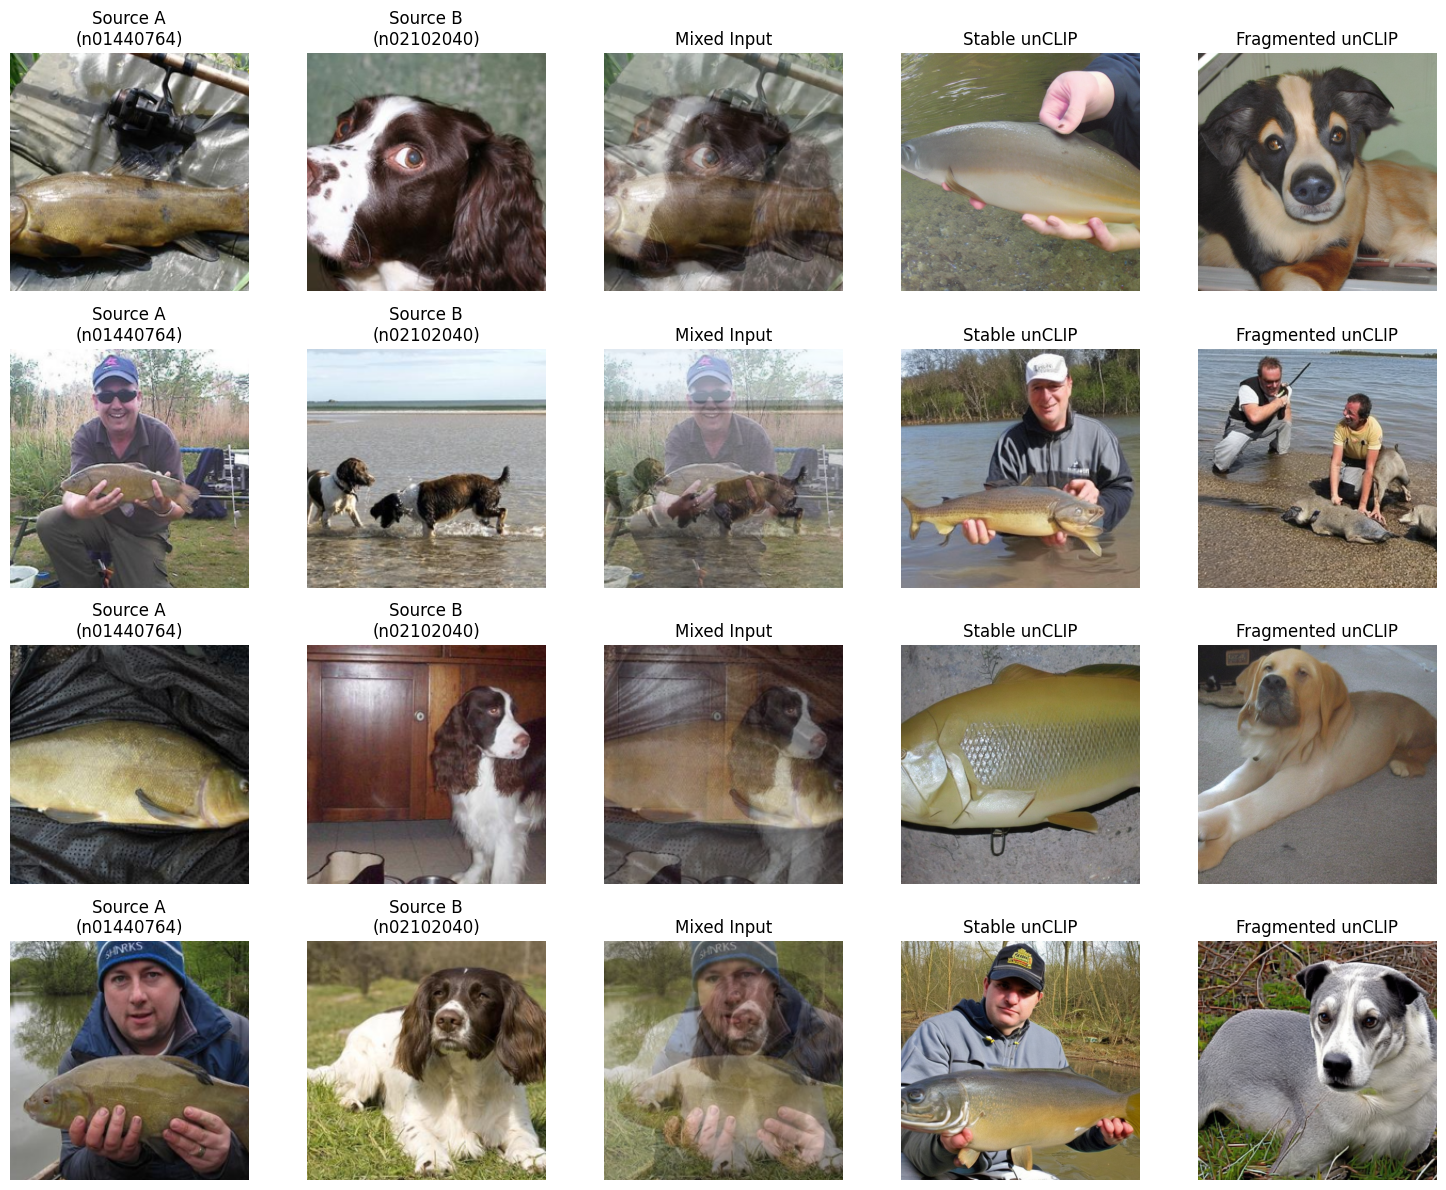

In [7]:

columns = ["Source A", "Source B", "Mixed Input", "Stable unCLIP", "Fragmented unCLIP"]
num_cols = len(columns)
fig, axes = plt.subplots(num_recon, num_cols, figsize=(3 * num_cols, 3 * num_recon))
row_pairs = mix_pairs_valid[:num_recon].tolist() if mix_pairs_valid is not None else sample_pair_labels[:num_recon]

for row in range(num_recon):
    class_a = class_names[row_pairs[row][0]] if row_pairs else "class A"
    class_b = class_names[row_pairs[row][1]] if row_pairs else "class B"

    images = [
        source_pairs[row][0],
        source_pairs[row][1],
        mixed_inputs[row],
        recon_tensors[row],
        fragment_tensors[row],
    ]

    for col in range(num_cols):
        axes[row, col].imshow(images[col].permute(1, 2, 0).numpy())
        if col == 0:
            axes[row, col].set_title(f"{columns[col]}\n({class_a})")
        elif col == 1:
            axes[row, col].set_title(f"{columns[col]}\n({class_b})")
        else:
            axes[row, col].set_title(columns[col])
        axes[row, col].axis("off")

plt.tight_layout()
